# Rover Analytics 

## Question 5: New Conversation Flow A/B Test

In [60]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


In [61]:
AB_df = pd.read_csv("csvs/people_testsegmentation.csv") #read in test dataset
                                                        #note: person_id matches people_person

In [62]:
conversations = pd.read_csv('csvs/conversations_conversation.csv') #read in conversations_conversations dataframe
                                                                   #note: requester_id matches people_person id.
                                                                   #we can likely merge dataframes based on this feature.

In [63]:
conversations.head(1)

,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
0,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaN,NaN


In [64]:
webpage_test = AB_df[AB_df['test_name']  == 'New Conversation Flow'] #this gives us the webpage dataframe

In [65]:
test_conversations = pd.merge(left=webpage_test, right=conversations, 
                                  left_on=webpage_test['person_id'], right_on=conversations['requester_id'])

#merge webpage_test dataframe with the conversations dataframe to look at conversations leading to bookings

In [66]:
test_conversations.head() #examine the merge

,key_0,id_x,test_name,test_group,added_x,person_id,id_y,start_date,end_date,units,added_y,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
0,64393,64394,New Conversation Flow,variant,2018-07-16 10:17:53.460035,64393,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaN,NaN
1,64392,64395,New Conversation Flow,holdout,2018-08-01 10:20:48.626868,64392,2,2018-08-10,2018-08-16,6,2018-08-01 10:20:48.626868,132,NaN,64392,10126,NaN,NaN
2,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,3,2018-06-16,2018-06-19,3,2018-06-05 16:46:39.542467,168,NaN,64391,20677,NaN,NaN
3,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,4,2018-07-13,2018-07-20,7,2018-07-02 09:12:22.275923,490,NaN,64391,3847,NaN,NaN
4,64389,64397,New Conversation Flow,variant,2018-06-21 16:02:48.694725,64389,5,2018-07-02,2018-07-07,5,2018-06-21 16:02:48.694725,140,NaN,64389,9982,NaN,NaN


In [67]:
no_book = test_conversations['booked_at'].isna()

In [68]:
test_conversations['not_booked'] = no_book.astype(int) #cast boolean no_book as 0s and 1s (0 False and 1 True)

In [69]:
test_conversations_variant = test_conversations[test_conversations['test_group'] == 'variant']

In [70]:
test_conversations_holdout = test_conversations[test_conversations['test_group'] == 'holdout']

In [71]:
def binary_encode(x):
    if x == 'variant':
        return 1
    else:
        return 0

In [72]:
test_conversations['test_group_binary'] = test_conversations['test_group'].apply(lambda x: binary_encode(x))
#label those in the test group as 1, else label 0

In [73]:
def booked_binary(x):
    if x == 1:
        return 0
    else:
        return 1

In [74]:
test_conversations['booked'] = test_conversations['not_booked'].apply(lambda x: booked_binary(x)) 
#label those that booked as a 1, else label 0
                    

In [75]:
test_conversations.head() #check to make sure function is applied correctly

,key_0,id_x,test_name,test_group,added_x,person_id,id_y,start_date,end_date,units,added_y,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at,not_booked,test_group_binary,booked
0,64393,64394,New Conversation Flow,variant,2018-07-16 10:17:53.460035,64393,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaN,NaN,1,1,0
1,64392,64395,New Conversation Flow,holdout,2018-08-01 10:20:48.626868,64392,2,2018-08-10,2018-08-16,6,2018-08-01 10:20:48.626868,132,NaN,64392,10126,NaN,NaN,1,0,0
2,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,3,2018-06-16,2018-06-19,3,2018-06-05 16:46:39.542467,168,NaN,64391,20677,NaN,NaN,1,0,0
3,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,4,2018-07-13,2018-07-20,7,2018-07-02 09:12:22.275923,490,NaN,64391,3847,NaN,NaN,1,0,0
4,64389,64397,New Conversation Flow,variant,2018-06-21 16:02:48.694725,64389,5,2018-07-02,2018-07-07,5,2018-06-21 16:02:48.694725,140,NaN,64389,9982,NaN,NaN,1,1,0


### Group by person and then do t_test on the number of bookings for the two conditions.  Also, look at baseline bookings before the test was implemented.


In [84]:
test_conversations['added_y'] = pd.to_datetime(test_conversations['added_y'])

In [86]:
start_date = pd.to_datetime('2018-04-04')

In [88]:
test_conv_filtered = test_conversations[test_conversations['added_y'] >= start_date]

In [91]:
test_conv_baseline = test_conversations[test_conversations['added_y'] < start_date]

In [95]:
sum_bookings = test_conv_filtered.groupby(['requester_id'])['booked'].sum() #aggregate by person

In [96]:
sum_bookings = sum_bookings.reset_index()

In [97]:
holdout_customers = test_conversations_holdout['requester_id']

In [98]:
variant_customers = test_conversations_variant['requester_id']

In [99]:
holdout_sum = sum_bookings[sum_bookings['requester_id'].isin(holdout_customers)]

In [100]:
variant_sum = sum_bookings[sum_bookings['requester_id'].isin(variant_customers)]

In [101]:
overlap = holdout_sum[holdout_sum['requester_id'].isin(variant_sum['requester_id'])]

In [102]:
overlap #check for no overlap between holdout and variant customers

,requester_id,booked


In [103]:
sum(~webpage_test['person_id'].isin(test_conversations['requester_id']))#check to make sure we aren't missing any test
                                                                        #cases

0

In [105]:
t_test = stats.ttest_ind(holdout_sum['booked'], variant_sum['booked'], equal_var=False)
t_test

Ttest_indResult(statistic=-9.511803072029483, pvalue=2.0490136819410357e-21)

In [106]:
len(holdout_sum) + len(variant_sum) -2 #degrees of freedom

23383

#### With t(23383) = -9.512 and p< 0.0001, reject the null of no difference in mean booking rates between variant and holdout groups.

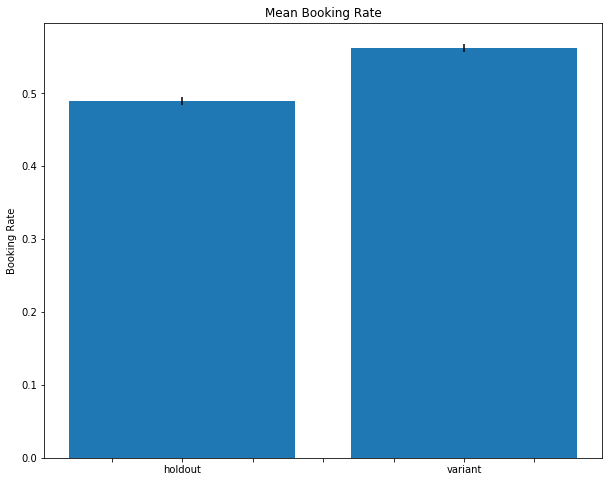

In [116]:
fig, ax = plt.subplots(figsize=(10,8))
x = [1, 2]
y = [holdout_sum['booked'].mean(), variant_sum['booked'].mean()]
std_err = [holdout_sum['booked'].sem(), variant_sum['booked'].sem()]
ax.bar(x, y, yerr=std_err)
ax.set_xticklabels(['','','holdout','', '','','variant',''])
ax.set_ylabel("Booking Rate")
_x=ax.set_title("Mean Booking Rate")

###  Look to see if baselines differ between the groups.

In [118]:
baseline_bookings = test_conv_baseline.groupby(['requester_id'])['booked'].sum()

In [122]:
baseline_bookings = baseline_bookings.reset_index()

In [146]:
len(baseline_bookings)

9112

In [123]:
holdout_baseline = baseline_bookings[baseline_bookings['requester_id'].isin(holdout_customers)]

In [126]:
variant_baseline = baseline_bookings[baseline_bookings['requester_id'].isin(variant_customers)]

In [135]:
t_test_baseline = stats.ttest_ind(holdout_baseline['booked'], variant_baseline['booked'], equal_var=False)
t_test_baseline

Ttest_indResult(statistic=-1.2231163837807353, pvalue=0.2213176176855464)

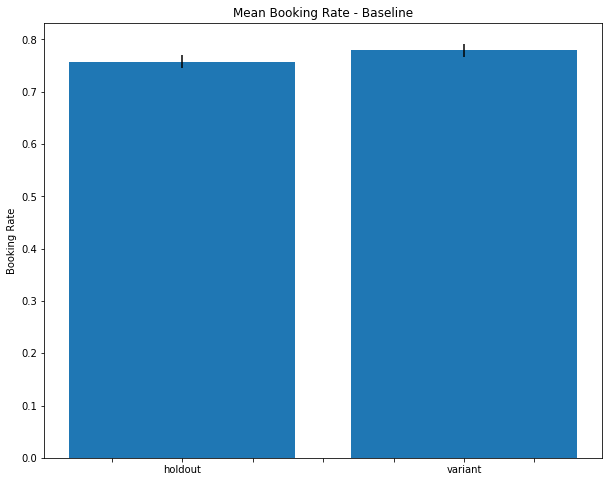

In [137]:
fig, ax = plt.subplots(figsize=(10,8))
x = [1, 2]
y = [holdout_baseline['booked'].mean(), variant_baseline['booked'].mean()]
std_err = [holdout_baseline['booked'].sem(), variant_baseline['booked'].sem()]
ax.bar(x, y, yerr=std_err)
ax.set_xticklabels(['','','holdout','', '','','variant',''])
ax.set_ylabel("Booking Rate")
_x=ax.set_title("Mean Booking Rate - Baseline")

A t-test examining users that were later assigned to the variant and holdout groups prior to test assignment showed no significant difference in mean booking rates (t(9110), p-value = 0.22).  However, it is worth noting that the variant group's baseline booking rate was slightly higher than the holdout group.  These owners that were assigned to the variant group may have influenced the outcomes of the A/B test. It is reasonable to conjecture that, due to increased trust with the booking services at Rover, the users later assigned to the variant group were going to increase their booking rates at a higher rate than the holdout group regardless of changes in the UI platform.  It may be worth considering a crossover design where the holdout users are switched to the new design and the variant users back to the old platform to see if booking rate changes still persist.  

Another possible issue with the study design is the exclusion of the providers from the UI changes.  It is possible that the providers could be more (or less) effective in their communication with the UI changes, and that would influence booking rates for the owners.  